<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Lab-1/Linde-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report explores different implementations regarding the Stokes equations, as used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology. The effects on stability of the pressure field of Taylor-Hood vs equal order mixed element methods are explored, as well as the direction of flow. Finally, Brezzi-Pitkäranta stabilization was implemented so that equal ordder mixed element methods could also give a stable solution. 

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [128]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

**Define domain and mesh**

The domain is a channel of length 4 and height 2 with a circular hole of radius 0.3 in the middle. The mesh has resolution of 32, which means the height of one element in the mesh is approximately 1/32. The mesh then get refined once in a radius of 1 around the midpoint of the circular hole. 

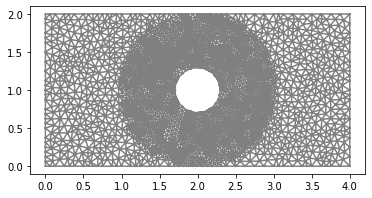

In [130]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.3), resolution)
# mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

The Taylor-Hood mixed finite element space uses continuous piecewise quadratic approximation of the velocity (VE) and continuous piecewise linear approximation of the pressure (QE). 

We also test the result on equal order interpolation to check that the results are stable for Taylor-Hood and unstable for equal interpolation, and to see how the unstability manifests itself in our result. 

In [0]:
# Generate mixed finite element spaces (for velocity and pressure), Taylor-Hood
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 2)
WE = VE * QE

# Generate mixed finite element spaces (for velocity and pressure), equal order interpolation
# VE = VectorElement("CG", mesh.ufl_cell(), 1)
# QE = FiniteElement("CG", mesh.ufl_cell(), 1)
# WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions**

In order to flip the direction of the flow, I switched the inflow boundary and outflow boundary, and changed the sign of the expression in uin, so that the velocity is in the opposite direction. 

In [0]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
# For reversed order: "-4*x[1]... instead of "4*x[1]...
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
# For reversed order: exchange ib and ob
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Results for different tests**

Below I have included visualisations made using paraview of the results from all the different tests I did. 

It shows that the Taylor-Hood mixed element method gives a smooth pressure field, whereas the equal order methods display a checkered pattern, which points toward an unstable solution.

Reversing the flow using the Taylor-Hood mixed element method gives the exact same solution but mirrored, which is as expected since the hole is exactly in the middle, so the conditions are the same, whichever way the flow goes. 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


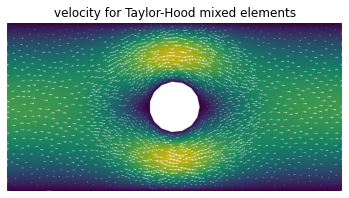

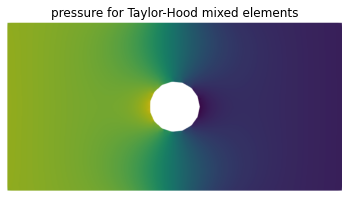

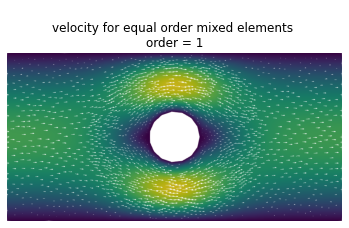

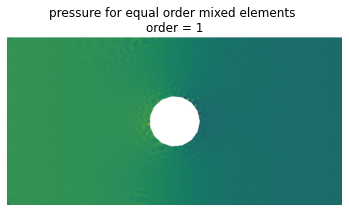

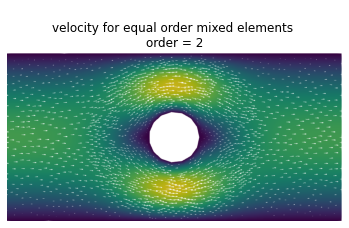

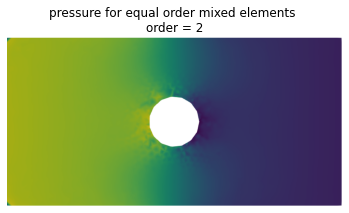

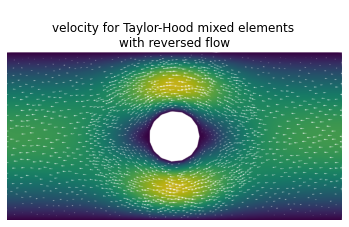

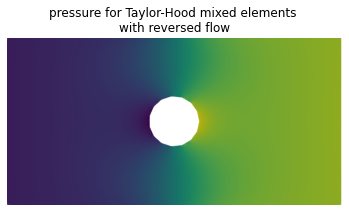

In [135]:
from google.colab import drive
drive.mount('/content/drive')

plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/uTH.png'))
plt.title("velocity for Taylor-Hood mixed elements")
plt.axis("off")
plt.show()
plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/pTH.png'))
plt.axis("off")
plt.title("pressure for Taylor-Hood mixed elements")
plt.show()

plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/ueoi1.png'))
plt.axis("off")
plt.title("\nvelocity for equal order mixed elements \norder = 1")
plt.show()
plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/peoi1.png'))
plt.title("pressure for equal order mixed elements \norder = 1")
plt.axis("off")
plt.show()

plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/ueoi2.png'))
plt.axis("off")
plt.title("\nvelocity for equal order mixed elements \norder = 2")
plt.show()
plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/peoi2.png'))
plt.title("pressure for equal order mixed elements \norder = 2")
plt.axis("off")
plt.show()

plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/uTHrev.png'))
plt.title("\nvelocity for Taylor-Hood mixed elements \nwith reversed flow")
plt.axis("off")
plt.show()
plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/pTHrev.png'))
plt.title("pressure for Taylor-Hood mixed elements \nwith reversed flow")
plt.axis("off")
plt.show()

**Define and solve variational problem**

Here we implement Brezzi-Pitkäranta stabilization when calculating the residual. We do this by adding a term

$s(P,q)=C\int (h^2 \nabla P·\nabla q )dx$

when calculating the residual. I includded a visualisation made using paraview for comparison's sake. We can compare it to the result for "pressure for equal order mixed elements order = 2" above to see how the stabilization has affected the result. The pressure field is again smooth rather than displaying the checkered pattern.

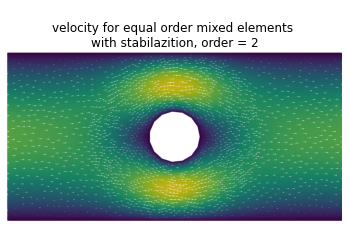

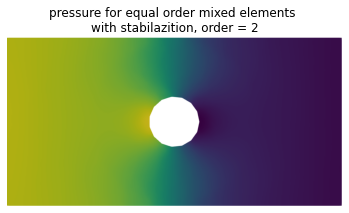

In [140]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds + h*h*inner(grad(p),grad(q))*dx - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w) 

plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/uStab.png'))
plt.title("\nvelocity for equal order mixed elements \nwith stabilazition, order = 2")
plt.axis("off")
plt.show()
plt.imshow(mpimg.imread('/content/drive/My Drive/imagesCFM/pStab.png'))
plt.title("pressure for equal order mixed elements \nwith stabilazition, order = 2")
plt.axis("off")
plt.show()

**Visualize solution**

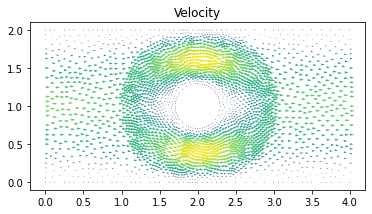

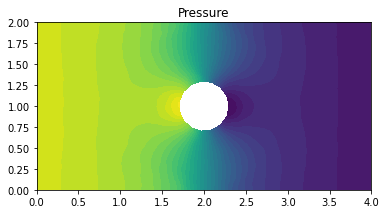

In [134]:
!rm results-Test/*

# Open files to export solution to Paraview
file_u = File("results-Test/u.pvd")
file_p = File("results-Test/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure()
plot(u1, title="Velocity")

plt.figure()
plot(p1, title="Pressure")
        
plt.show()

# Export files
# !tar -czvf results-Stokes.tar.gz results-Stokes
# files.download('results-Stokes.tar.gz')

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  